In [1]:
# import all the libraries
import os, re, time, math
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import pysal as ps
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from spglm.family import Binomial
import multiprocessing as mp
from spglm.glm import GLM, GLMResults
from datetime import datetime
from sklearn.utils import resample
from shapely.geometry import Polygon

C:\Users\gsl\Anaconda3\envs\prat_env\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\Users\gsl\Anaconda3\envs\prat_env\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
epoch1_file = '../Tables/220209_Kathmandu_Epoch1_GWLR_PT_V1.csv'
df_epoch1 = pd.read_csv(epoch1_file)

# define a function for alphanumeric filename sorting
def sorted_nicely(l): 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

df_epoch1 = df_epoch1[sorted_nicely(df_epoch1.keys())]

print(df_epoch1.keys())

Index(['2000_BD_K3', '2000_BD_K13', '2000_VD_K5', '2000_dist_builtup',
       'dist_hospitals', 'elevation', 'growth_00_10', 'latitudes',
       'longitudes', 'slope'],
      dtype='object')


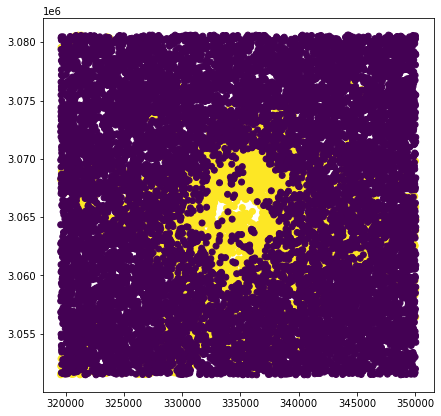

In [3]:
# create geodatafram from pandas table
gdf_epoch1 = gpd.GeoDataFrame(df_epoch1, geometry=gpd.points_from_xy(df_epoch1.longitudes, df_epoch1.latitudes))
gdf_epoch1.crs = 'epsg:32645'
"""
sample_size = 15000

# stratified sample classes
built = gdf_epoch1.loc[gdf_epoch1.growth_00_10==1]
unbuilt = gdf_epoch1.loc[gdf_epoch1.growth_00_10==0]

print('Number of records in each class:')
print('Built: %d, Unbuilt: %d' % (built.shape[0], unbuilt.shape[0]))

# Downsample the majority class
built = resample(built,
                 replace = False, # sample without replacement
                    n_samples = int(sample_size / 2), # match minority n
                    random_state = 2)

unbuilt = resample(unbuilt,
                  replace = False, # sample without replacement
                  n_samples = int(sample_size / 2), # match minority n
                  random_state = 2)

print('Number of records in balanced classes:')
print('Built: %d, Unbuilt: %d' % (built.shape[0], unbuilt.shape[0]))

# Combine the balanced features
gdf_epoch1 = pd.concat([built, unbuilt], axis=0)
"""
fig, ax = plt.subplots(figsize = (7, 7))
gdf_epoch1.plot('growth_00_10', ax=ax)
plt.show()

In [4]:
# set up the data 
variables = ['2000_BD_K3', '2000_BD_K13', '2000_VD_K5', '2000_dist_builtup',
                       'dist_hospitals', 'elevation', 'slope']
x_epoch1 = gdf_epoch1[variables].to_numpy()
y_epoch1 = gdf_epoch1['growth_00_10'].to_numpy().reshape((-1, 1))
g_coords = list(zip(gdf_epoch1.longitudes.values, gdf_epoch1.latitudes.values))

print(x_epoch1.shape)
print(y_epoch1.shape)

(25000, 7)
(25000, 1)


In [ ]:
# search for optimum bandwidth
t1 = time.time()

# create parallel processing
n_proc = mp.cpu_count()
pool = mp.Pool(n_proc)

# create search for bandwidth
gwr_selector = Sel_BW(g_coords, y_epoch1, x_epoch1, family=Binomial())
gwr_bw = gwr_selector.search(pool=pool, criterion='AICc', search_method='interval', bw_min=950, bw_max=1050, interval=50)

# close the pool
pool.close()
pool.join()

t2 = time.time()
print('Total time taken: %.2f minutes' % ((t2 - t1) / 60))

print(gwr_bw)
# earlier was 724

Total time taken: 14.14 minutes
1000


In [5]:
gwr_bw = 1000

In [6]:
# create parallelisation
n_proc = 30 #two processors
pool = mp.Pool(n_proc)

# fit the model, print basic stats
gwr_model = GWR(g_coords, y_epoch1, x_epoch1, gwr_bw, family=Binomial())
gwr_results = gwr_model.fit(pool=pool)

# Close the pool when you finish
pool.close()
pool.join()

# print global stats
print(gwr_results.resid_ss) #1402.0653773759514
print(gwr_results.aic) #9561.290869417648
print(gwr_results.aicc) #9585.725977906948

2387.2828913275553
15716.43099785971
15729.632950018777


In [7]:
gwr_results.summary()

Model type                                                         Binomial
Number of observations:                                               25000
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Deviance:                                                         20357.587
Log-likelihood:                                                  -10178.793
AIC:                                                              20373.587
AICc:                                                             20373.592
BIC:                                                            -232727.178
Percent deviance explained:                                           0.413
Adj. percent deviance explained:                                      0.412

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [13]:
# export the shapefile with the coefficients
params = gwr_results.params

print(params.shape)

out_list = ['Intercept'] + variables
for x in range (0, 8):
    gdf_epoch1['x%d-%s'%(x, out_list[x])] = params[:, x]
print(gdf_epoch1.keys())

time_stamp = datetime.now().strftime('%y%m%d')
gdf_epoch1.to_file('../output/%s_Kathmandu_Epoch1_GWR_Output_utm45n_PT_V1.shp' % (time_stamp))

(25000, 8)
Index(['2000_BD_K3', '2000_BD_K13', '2000_VD_K5', '2000_dist_builtup',
       'dist_hospitals', 'elevation', 'growth_00_10', 'latitudes',
       'longitudes', 'slope', 'geometry', 'x0-Intercept', 'x1-2000_BD_K3',
       'x2-2000_BD_K13', 'x3-2000_VD_K5', 'x4-2000_dist_builtup',
       'x5-dist_hospitals', 'x6-elevation', 'x7-slope'],
      dtype='object')


In [15]:
# perform stationarity test
stationarity_df = pd.DataFrame(index=variables, columns=['Q1', 'Q3', 'IQR', 'SE', 'IQR-2*SE'])

# fit a global model
glm_model = GLM(y_epoch1, x_epoch1, family=Binomial())
glm_results = glm_model.fit()

#print(dir(glm_results))
#print(glm_results.bse)

for n, var in enumerate(variables):
    q3, q1 = np.percentile(params[:, n], [75, 25])
    iqr = np.round(q3 - q1, 3)
    
    se = np.round(glm_results.bse[n], 3)
    #std = math.sqrt(gdf_epoch1.shape[0]) * se
    #print(2*std, iqr, se, var)
    
    stationarity_df.loc[var] = q1, q3, iqr, se, iqr-2*se
    
print(stationarity_df)
stationarity_df.to_csv('../output/%s_Kathmandu_Epoch1_GWR_StationarityTest.csv' % (time_stamp))

                         Q1        Q3    IQR     SE IQR-2*SE
2000_BD_K3        -3.823837    0.7079  4.532  0.015    4.502
2000_BD_K13        0.176484  0.745943  0.569  0.022    0.525
2000_VD_K5        -0.058952  1.599802  1.659  0.024    1.611
2000_dist_builtup -0.404015  0.062526  0.467  0.017    0.433
dist_hospitals      0.85472  4.628077  3.773  0.018    3.737
elevation         -0.965641  1.977482  2.943  0.021    2.901
slope             -3.021609  0.132401  3.154   0.02    3.114


In [16]:
# export the details of the GLM and the GWR models to CSV file
column_names = ['Variable', 'Min', '2 Percentile', 'Mean', 'Median', '98 Percentile', 'Max', 'SD']
gwr_coefficients = pd.DataFrame([], columns=column_names)

XNames = ['Intercept'] + variables
for i in range(gwr_results.params.shape[1]):
    p2, p98 = np.percentile(gwr_results.params[:, i], [2, 98])
    
    temp_series = pd.Series((XNames[i], np.min(gwr_results.params[:, i]), p2,
                             np.mean(gwr_results.params[:, i]), np.median(gwr_results.params[:, i]),
                             p98, np.max(gwr_results.params[:, i]),
                             np.std(gwr_results.params[:, i])
                            ),
         index = column_names)
    
    gwr_coefficients = pd.concat([gwr_coefficients, pd.DataFrame([temp_series], 
                                                                 columns=column_names)], 
                                 axis=0, ignore_index=False)

# add details of the GLM model
gwr_coefficients.reset_index(drop=True, inplace=True)
gwr_coefficients = pd.concat([gwr_coefficients, 
                             pd.DataFrame([glm_results.params.flatten(), glm_results.bse.flatten()], 
                                          index=['GLM Est.', 'SE']).transpose()], 
                             axis=1, ignore_index=True)
gwr_coefficients.columns = column_names + ['GLM Est.', 'GLM SE']
gwr_coefficients = gwr_coefficients.round(3)

print(gwr_coefficients)
gwr_coefficients.to_csv('../output/%s_Kathmandu_Epoch1_GWR_Coefficients.csv' % (time_stamp))

            Variable           Min  2 Percentile          Mean  Median  \
0          Intercept -3.177186e+16      -105.690 -1.273126e+12  -0.989   
1         2000_BD_K3 -1.551020e+15        -1.705  2.096854e+11   0.430   
2        2000_BD_K13 -6.070715e+16      -179.722 -2.144500e+12   0.350   
3         2000_VD_K5 -4.569226e+14        -1.314 -1.858610e+10  -0.164   
4  2000_dist_builtup -7.262890e+13        -1.496  2.345712e+10   2.220   
5     dist_hospitals -5.143215e+14        -6.750  7.268230e+10   0.364   
6          elevation -1.384414e+15       -14.543 -6.076032e+10  -1.110   
7              slope -2.746769e+14        -1.937  6.274140e+09  -0.283   

   98 Percentile           Max            SD  GLM Est.  GLM SE  
0         13.584  9.799304e+14  2.011412e+14     0.000   0.015  
1          4.757  6.458366e+15  4.206049e+13     0.167   0.022  
2         26.242  3.988479e+15  3.852688e+14     0.331   0.024  
3          1.722  3.977279e+13  2.916217e+12    -0.180   0.017  
4       

# Plot the coefficients

[-6.62234823  0.0999876   0.33000071  0.54550107  0.85488245  9.3189363 ]


<AxesSubplot:>

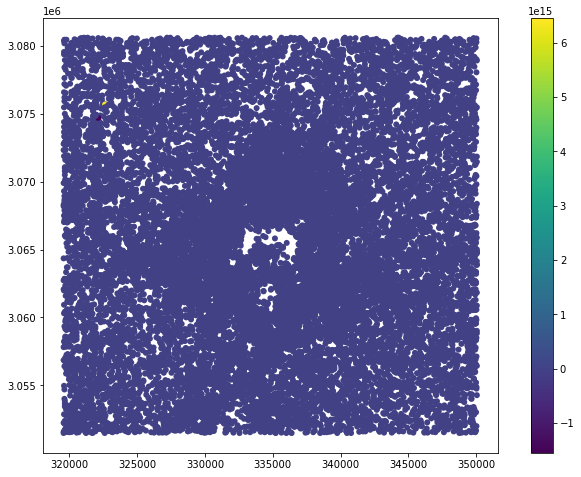

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

quantiles = np.quantile(gdf_epoch1['x1'], [0.001, .20, .40, .60, .80, .99])

print(quantiles)
gdf_epoch1.plot(
    ax=ax,
    column='x1', 
    linewidth=0,
    legend=True,
    vmin=quantiles[0],
    vmax=quantiles[-1]
    
               )